Yesterday we had a first look at how calcium imaging data looks like. Today we will take a deep dive into how to convert that data into clean and meaningful traces that describe the activity of individual neurons. We will structure today by looking at different scenarios in calcium imaging experiments, describing the problems that can arise, and what solutions are on-hand to fix them. 
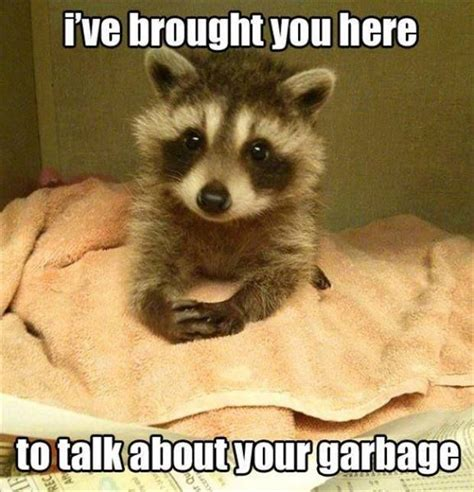
There is a famous saying in data analysis " Garbage in, garbage out" - it basically means no amount of fancy modeling will save you if you don't have good raw data. The aim of today is to help you keep your own data as clean and pretty as possible, and also recognize warning signs in other people's data in papers or collaborations.

### Converting Terabytes to Megabytes
One of the most prominent steps in analyzing your movies is to decide which parts of the signal belong to individual structures eg neurons.

### The Want-To-Have-My-Cake-and-eat-it-too scenario

Imagine you recently learned about the controversy around mirror neurons and decided you're going to be the first to show mirror neurons in the mouse. You decide you will need to measure many neurons in order to find the elusive mirror neurons, and since you expect they will be in the easy to reach motor cortex, you decide to use calcium imaging to find them. You record hours of movies of mice doing things, express GCaMP7 in mouse M1, put your mouse in front of the TV and fire up the 2P. At the beginning the signals are bright and beautiful, but one hour into your mouse movie marathon, you can barely see the neurons. What is happening?!

#### Bleaching
Fluorophores bleach. Some fluorophores bleach more than others. Normalize your F trace. df/f
+ moving window F0
+ zscore
+ trial baseline